In [1]:
# Reference: https://github.com/marcoancona/DeepExplain/blob/master/examples/mint_cnn_keras.ipynb
import sys, os
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

# importing "Skater" related functions
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal, equal_to
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Create a Tensorflow session and register it with Keras. Keras will use this session to initialize all the variables
# Reference: https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
sess = tf.Session()
K.set_session(sess)

### Data Transformation

In [180]:
# Dataset: 
# The MNIST dataset has 60,000 training examples, and a test set of 10,000 examples.
# For more details: http://yann.lecun.com/exdb/mnist/

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Train a model

In [44]:
# Build and train a network.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 58s - loss: 0.2249 - acc: 0.9323 - val_loss: 0.0584 - val_acc: 0.9812
Epoch 2/3
60000/60000 [==============================] - 58s - loss: 0.0569 - acc: 0.9830 - val_loss: 0.0498 - val_acc: 0.9841
Epoch 3/3
60000/60000 [==============================] - 58s - loss: 0.0378 - acc: 0.9885 - val_loss: 0.0354 - val_acc: 0.9872


### Evaluating the model

In [45]:
score_train = model.evaluate(x_train, y_train)
score_test = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: {}".format(score_test[0]))
print("Train accuracy: {}".format(score_train[1]))
print('Test accuracy:', score_test[1])

59968/60000 [============================>.] - ETA: 0sTest loss: 0.03535767059237696
Train accuracy: 0.9929333333333333
Test accuracy: 0.9872


### Quick peek at the original images

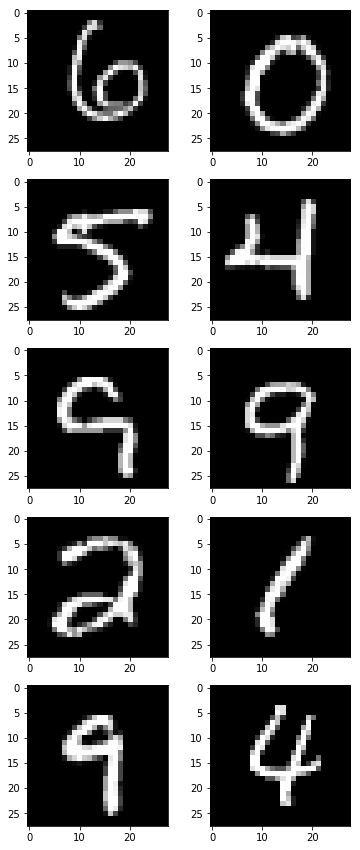

In [6]:
%matplotlib inline
xs = x_test[100:110]
ys = y_test[100:110]

n_cols = 2
n_rows = int(len(xs)/2)
plt.figure(figsize=(3*n_cols, 3*n_rows))
for i in range(len(xs)):
    plt.subplot(5, 2, i+1)
    plt.imshow(xs[i].reshape(28,28), cmap='gray')

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### Persist the model for future use

In [46]:
# Persist the mode
model_yaml = model.to_yaml()
with open("model_mnist_cnn_3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_mnist_cnn_3.h5")
print("Saved model to disk")
yaml_file.close()

Saved model to disk


### Load the saved model

In [47]:
# Load the model
yaml_file = open('model_mnist_cnn_3.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_mnist_cnn_3.h5")
print("Loaded model from disk")

Loaded model from disk


##### Visualize an in-correct prediction

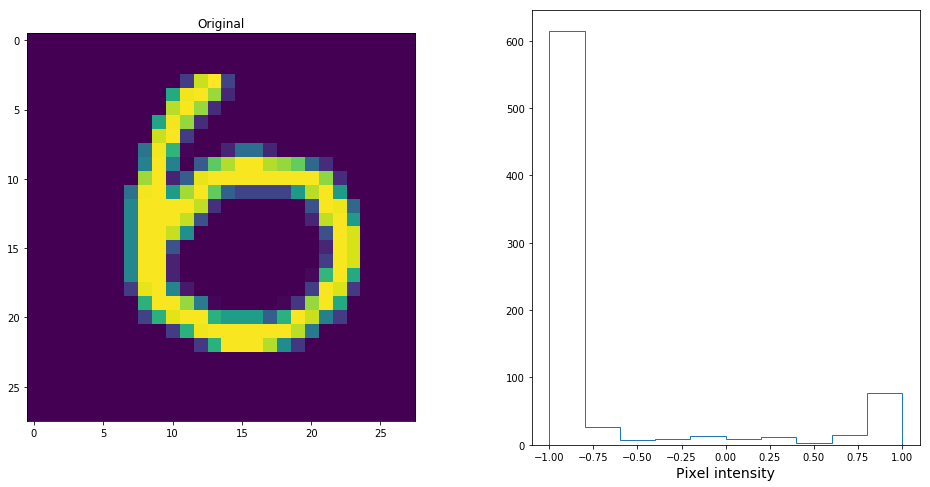

In [105]:
show_image(x_test[in_correct_prediction[0][0]].reshape(28, 28))

In [181]:
### Predictions on the selected input
input_x = x_test[100:110]
input_y = y_test[100:110]
final_prediction = loaded_model.predict_classes(input_x)
print(final_prediction)

10/10 [==============================] - 0s
[6 0 5 4 9 9 2 1 9 4]


(1, 28, 28, 1)


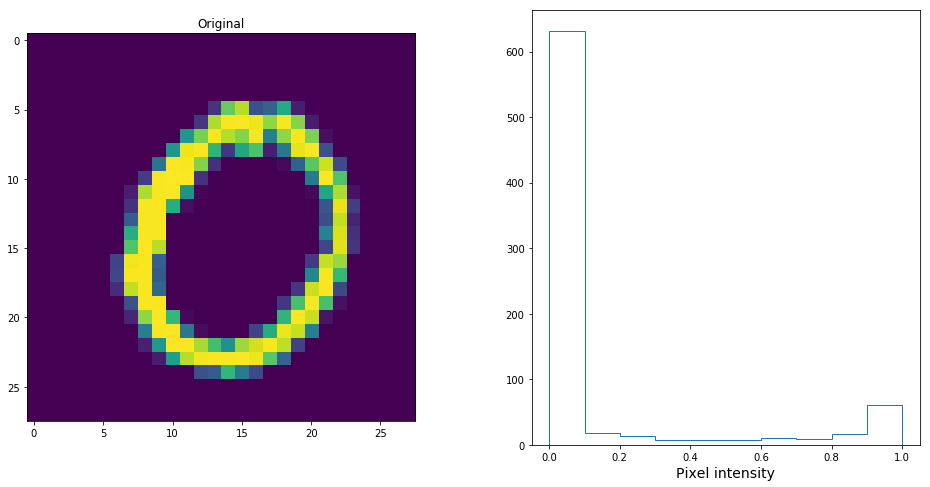

In [184]:
an_img = xs = x_test[101:102]
print(an_img.shape)
show_image(normalize(an_img[0]).reshape(28, 28))

### Lets ask Skater to help us with interpreting the the above build model

In [12]:
K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    # 1. Load the persisted model
    # 2. Retrieve the input tensor from the loaded model
    yaml_file = open('model_mnist_cnn_3.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights("model_mnist_cnn_3.h5")
    print("Loaded model from disk")
    input_tensor = loaded_model.layers[0].input
    output_tensor = loaded_model.layers[-2].output
    
    # 3. We will using the last dense layer(pre-softmax) as the output layer
    # 4. Instantiate a model with the new input and output tensor
    new_model = Model(inputs=input_tensor, outputs=output_tensor)
    target_tensor = new_model(input_tensor)
    xs = input_x
    ys = input_y
    print("X shape: {}".format(xs.shape))
    print("Y shape: {}".format(ys.shape))
    # Original Predictions
    print(loaded_model.predict_classes(xs))
    relevance_scores = di.explain('elrp', target_tensor * ys, input_tensor, xs)

Loaded model from disk
X shape: (10, 28, 28, 1)
Y shape: (10, 10)
10/10 [==============================] - 0s

2018-04-23 23:00:53,924 - LRP - INFO - Epsilon value: 0.0001
2018-04-23 23:00:53,925 - BaseGradient - INFO - Executing operations ...
2018-04-23 23:00:53,935 - LRP - DEBUG - Computing non-linear gradient with activation type Relu
2018-04-23 23:00:53,948 - LRP - DEBUG - Computing non-linear gradient with activation type Relu
2018-04-23 23:00:53,961 - LRP - DEBUG - Computing non-linear gradient with activation type Relu



[6 0 5 4 9 9 2 1 9 4]


#### Visualize interpretation

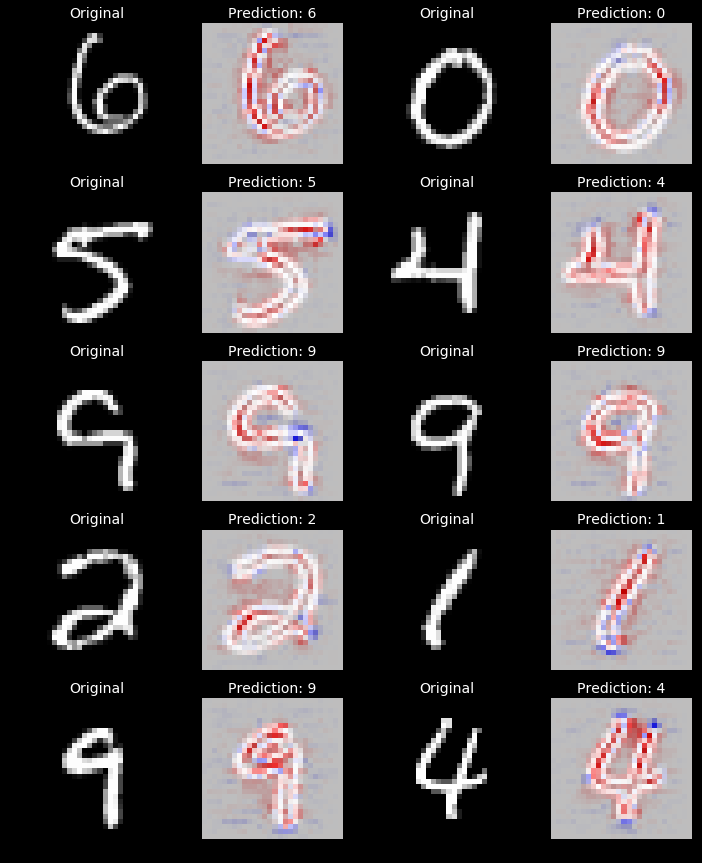

In [13]:
# Visualize the relevance computed
%matplotlib inline
# set the properties for text
font = {'family': 'avenir',
        'color':  'white',
        'weight': 'normal',
        'size': 14,
        }

n_cols = 4
n_rows = int(len(relevance_scores) / 2)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
fig.patch.set_facecolor('black')
for i, a in enumerate(relevance_scores):
    row, col = divmod(i, 2)
    visualize(xs[i].reshape(28, 28), cmap='gray', axis=axes[row, col*2], 
              alpha_edges=1.0, alpha_bgcolor=1).set_title('Original', fontdict=font)
    visualize(relevance_scores[i], xs[i], axis=axes[row, col*2+1], 
              alpha_edges=1.0, 
              alpha_bgcolor=0.75).set_title('Prediction: {}'.format(final_prediction[i]), fontdict=font)

(1, 28, 28, 1)


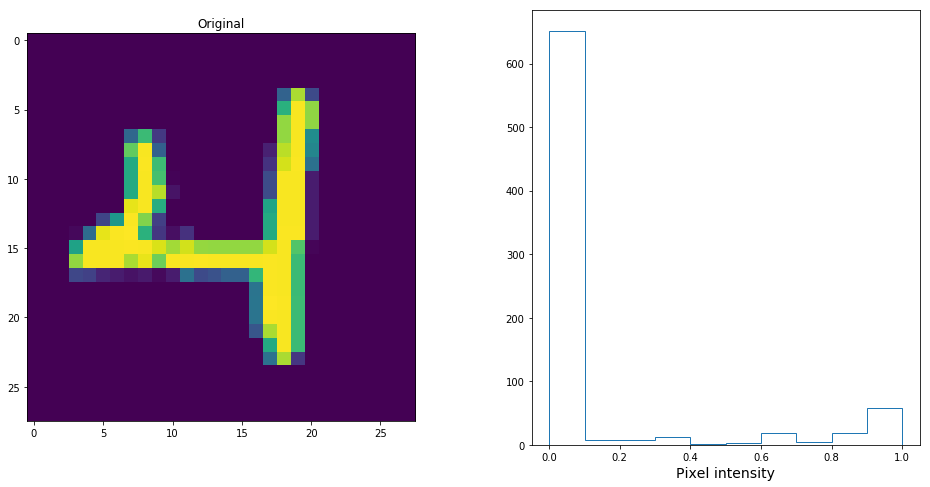

### Infer cause for in-corret predictions

#### Query for in-correct predictions

In [ ]:
predicted_classes = loaded_model.predict_classes(x_test)
# Convert the predicted classes to categorical format for further comparison
predicted_classes_categorical = [keras.utils.to_categorical(x_t, num_classes) for x_t in predicted_classes]

# flatten the above list to match the format of y_test
# Reference: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
flatten = lambda l: [item for sublist in l for item in sublist]
predicted_classes = np.asarray(flatten(predicted_classes_categorical))

assert predicted_classes.shape == y_test.shape

in_correct_prediction = np.where(predicted_classes != y_test)

In [111]:
index = 0
print("Ground Truth: {}".format(y_test[in_correct_prediction[0][index]]))
print("Predicted Class {}".format(predicted_classes[in_correct_prediction[0][index]]))

Ground Truth: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Predicted Class [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Visualize an in-correct prediction

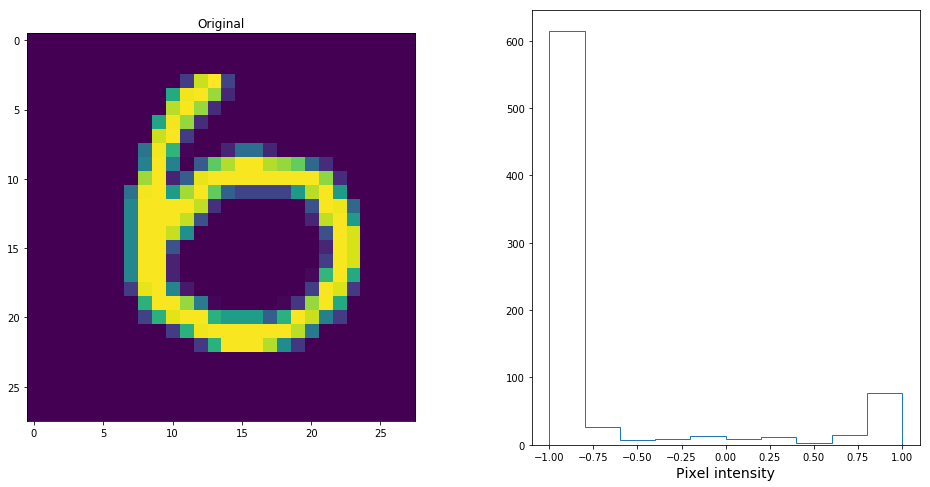

In [112]:
show_image(x_test[in_correct_prediction[0][index]].reshape(28, 28))

In [264]:
input_x_i = np.array([x_test[in_correct_prediction[0][index]], x_test[100:101][0], x_test[101:102][0]])
input_y_i = np.array([y_test[in_correct_prediction[0][index]], y_test[100:101][0], y_test[101:102][0]])

In [266]:
print(input_x_i.shape)
print(input_y_i.shape)

(3, 28, 28, 1)
(3, 10)


#### Lets ask Skater to help us with interpreting the the above build model

In [267]:
n_rows = 1
K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    # 1. Load the persisted model
    # 2. Retrieve the input tensor from the loaded model
    yaml_file = open('model_mnist_cnn_3.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights("model_mnist_cnn_3.h5")
    print("Loaded model from disk")
    input_tensor = loaded_model.layers[0].input
    output_tensor = loaded_model.layers[-2].output
    
    # 3. We will using the last dense layer(pre-softmax) as the output layer
    # 4. Instantiate a model with the new input and output tensor
    new_model = Model(inputs=input_tensor, outputs=output_tensor)
    target_tensor = new_model(input_tensor)
    xs = input_x_i
    ys = input_y_i
    print("X shape: {}".format(xs.shape))
    print("Y shape: {}".format(ys.shape))
    # Original Predictions
    print("Predicted Class: {}".format(loaded_model.predict_classes(xs)))
    relevance_scores = di.explain('elrp', target_tensor * ys, input_tensor, xs)

Loaded model from disk
X shape: (3, 28, 28, 1)
Y shape: (3, 10)
3/3 [==============================] - 0s

2018-04-24 01:58:40,558 - LRP - INFO - Epsilon value: 0.0001
2018-04-24 01:58:40,559 - BaseGradient - INFO - Executing operations ...
2018-04-24 01:58:40,569 - LRP - DEBUG - Computing non-linear gradient with activation type Relu
2018-04-24 01:58:40,582 - LRP - DEBUG - Computing non-linear gradient with activation type Relu
2018-04-24 01:58:40,595 - LRP - DEBUG - Computing non-linear gradient with activation type Relu



Predicted Class: [0 6 0]


#### Visualize interpretation

3/3 [==============================] - 0s
(3, 2)


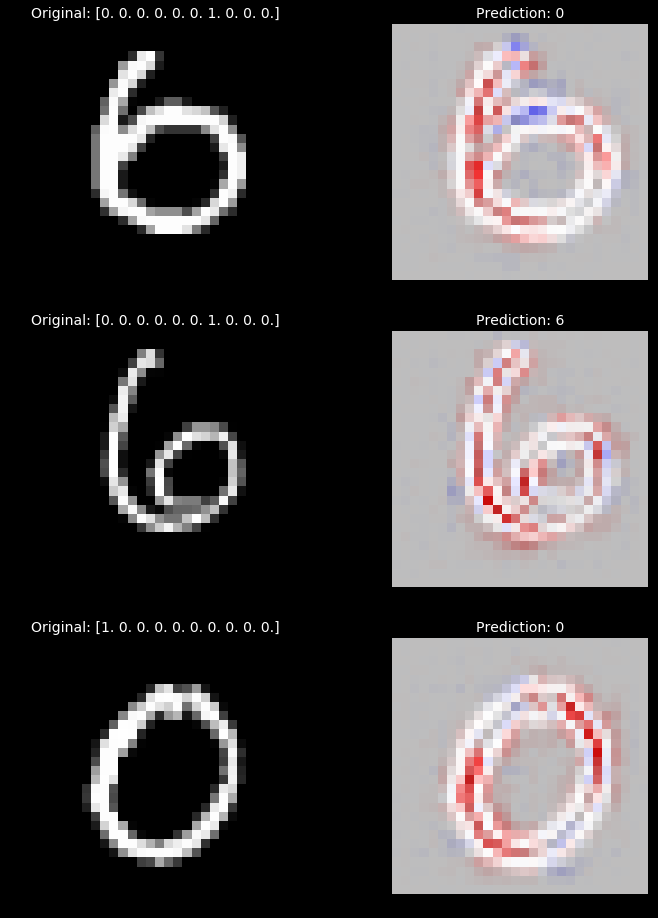

In [276]:
predicted_class = loaded_model.predict_classes(input_x_i)
# Visualize the relevance computed
%matplotlib inline
# set the properties for text
font = {'family': 'avenir',
        'color':  'white',
        'weight': 'normal',
        'size': 14,
        }

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8*2))
print(axes.shape)
fig.patch.set_facecolor('black')
for index in range(len(relevance_scores)):
    visualize(input_x_i[index].reshape(28, 28), cmap='gray', axis=axes[index][0], 
              alpha_edges=1.0, alpha_bgcolor=1).set_title('Original: {}'.format(input_y_i[index]), fontdict=font)

    visualize(relevance_scores[index], input_x_i[index], axis=axes[index][1], alpha_edges=1.0, 
              alpha_bgcolor=0.75).set_title('Prediction: {}'.format(predicted_class[index]), 
                                            fontdict=font)

### Generate adversarial example

#### 1. Measuring sensitivity by flipping pixels

(1, 28, 28, 1)


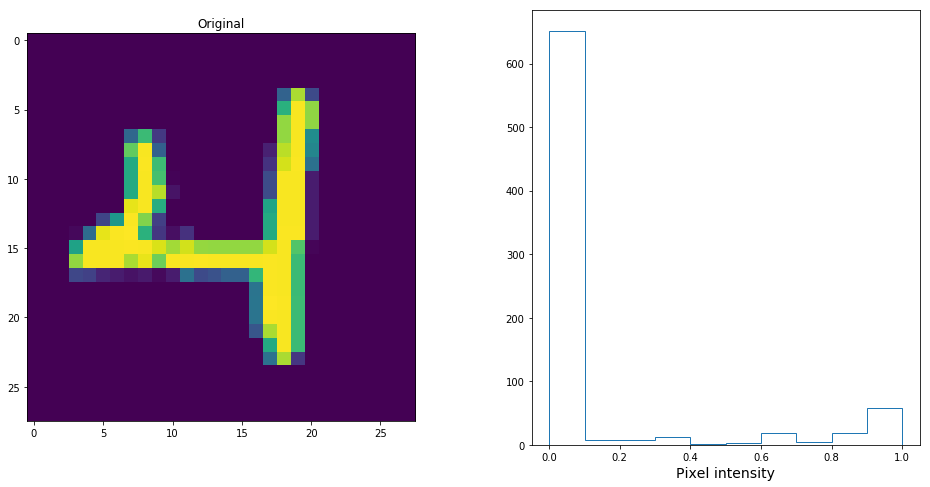

In [278]:
# Original test image used for model evaluation, can we identify the blind spots
%matplotlib inline
an_img = xs = x_test[103:104]
print(an_img.shape)
show_image(normalize(an_img[0]).reshape(28, 28))

2018-04-17 00:51:45,259 - skater.util.image_ops - INFO - Number of pixels matching the condition : 124
2018-04-17 00:51:45,260 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 124


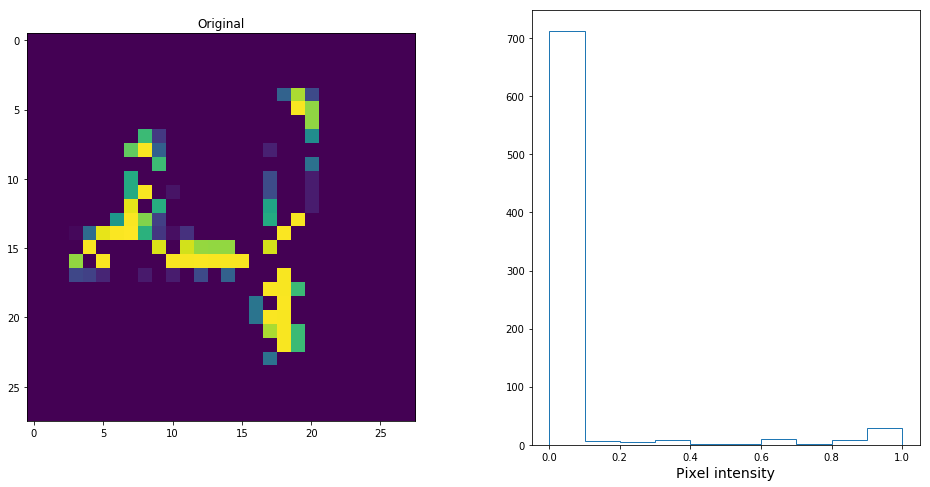

In [10]:
X = normalize(an_img[0]).reshape(28,28)
n_in_img = flip_pixels(X, 124, filtered_pixel=in_between(X, 0.2, 1.))
show_image(n_in_img)

In [11]:
an_img_x = n_in_img.reshape(1, 28, 28, 1)
an_img_y = np.zeros(10).astype(np.int64)
an_img_y[4] = 1
an_img_y = an_img_y.reshape(1, an_img_y.shape[0])
print("X input shape : {}".format(an_img_x.shape))
print("Y input shape : {}".format(an_img_y.shape))

print("Predicted Label : {}".format(loaded_model.predict_classes(an_img)))

K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    # 1. Load the persisted model
    # 2. Retrieve the input tensor from the loaded model
    retrieved_model = loaded_model
    input_tensor = retrieved_model.layers[0].input
    output_tensor = retrieved_model.layers[-2].output
    
    # 3. We will using the last dense layer(pre-softmax) as the output layer
    # 4. Instantiate a model with the new input and output tensor
    new_model = Model(inputs=input_tensor, outputs=output_tensor)
    target_tensor = new_model(input_tensor)
    xs = an_img_x
    ys = an_img_y
    relevance_scores = di.explain('elrp', target_tensor * ys, input_tensor, xs)

X input shape : (1, 28, 28, 1)
Y input shape : (1, 10)
1/1 [==============================] - 0s
Predicted Label : [4]


<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

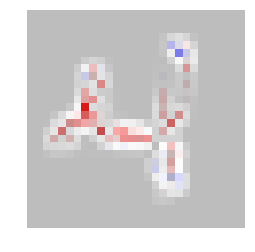

In [12]:
visualize(relevance_scores[0], xs[0], axis=plt, alpha_edges=1.0, alpha_bgcolor=0.75)